AMS 516 - Stochastic Volatility Option hedging

Members: 
Sahil Khaja Huzoor

Nick Koukounas

In [2]:
import torch,math
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
mu, r = 0.10, 0.02
kappa, theta, xi, rho = 2.0, 0.04, 0.30, -0.70
gamma = 2.0 # This is the risk aversion parameter under CARA utility function. For gamma > 0, the individual is risk averse, for gamma < 0, the individual is risk seeking. 

K, T = 100.0, 1.0 

#domains of stock price and volatility
X_min, X_max = -2.0*K, 2.0*K
S_min, S_max = 20.0, 400.0
v_min, v_max = 1e-4, 0.5

# sample sizes 
N_int  = 8000
N_tau0 = 2000
N_b    = 1000

# defining our payoff function

def call_payoff(S):
    return torch.clamp(S-K, min=0.0)


def sample_uniform(n, low, high):
    return low + (high - low) * torch.rand(n, 1, device=device)    
    

class FeedForwardNet(torch.nn.Module):
    def __init__(self, in_dim=4, h1=128, h2=128, h3=64):
        super().__init__()
        self.fc1 = torch.nn.Linear(in_dim, h1)
        self.fc2 = torch.nn.Linear(h1, h2)
        self.fc3 = torch.nn.Linear(h2, h3)
        self.out = torch.nn.Linear(h3, 1)
        self.act = torch.nn.Tanh()
    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        return self.out(x)

V_theta = FeedForwardNet().to(device)

opt = torch.optim.Adam(V_theta.parameters(), lr=1e-3)

def V_terminal(X, S):
    return -torch.exp(-gamma * (X - call_payoff(S)))

def V_and_grads(tau,X,S,v):
    tau.requires_grad_(True);S.requires_grad_(True);v.requires_grad_(True);X.requires_grad_(True)

    x = torch.cat([tau,X,S,v],dim = 1)
    V = V_theta(x) # My value function that is being approximated with all the parameters

    V_tau = torch.autograd.grad(V,tau,grad_outputs=torch.ones_like(V),retain_graph=True,create_graph=True)[0]
    V_X   = torch.autograd.grad(V, X,   grad_outputs=torch.ones_like(V),retain_graph=True, create_graph=True)[0]
    V_S   = torch.autograd.grad(V, S,   grad_outputs=torch.ones_like(V),retain_graph=True, create_graph=True)[0]
    V_v   = torch.autograd.grad(V, v,   grad_outputs=torch.ones_like(V),retain_graph=True, create_graph=True)[0]

    V_XX  = torch.autograd.grad(V_X, X, grad_outputs=torch.ones_like(V_X),retain_graph=True, create_graph=True)[0]
    V_SS  = torch.autograd.grad(V_S, S, grad_outputs=torch.ones_like(V_S),retain_graph=True, create_graph=True)[0]
    V_vv  = torch.autograd.grad(V_v, v, grad_outputs=torch.ones_like(V_v),retain_graph=True, create_graph=True)[0]

    V_XS  = torch.autograd.grad(V_X, S, grad_outputs=torch.ones_like(V_X),retain_graph=True, create_graph=True)[0]
    V_Xv  = torch.autograd.grad(V_X, v, grad_outputs=torch.ones_like(V_X),retain_graph=True, create_graph=True)[0]
    V_Sv  = torch.autograd.grad(V_S, v, grad_outputs=torch.ones_like(V_S),retain_graph=True, create_graph=True)[0]

    return V, V_tau, V_X, V_S, V_v, V_XX, V_SS, V_vv, V_XS, V_Xv, V_Sv

def hjb_residual(tau,X,S,v):
    V, V_tau, V_X, V_S, V_v, V_XX, V_SS, V_vv, V_XS, V_Xv, V_Sv = V_and_grads(tau, X, S, v)
    sqrtv = torch.sqrt(torch.clamp(v,min=1e-8))

    drift_X = r * X * V_X
    drift_v = kappa * (theta - v) * V_v
    diff_S  = 0.5 * v * S**2 * V_SS
    diff_v  = 0.5 * xi**2 * v * V_vv
    mix_Sv  = rho * xi * S * torch.clamp(v,min=1e-8) * V_Sv
    # These are all the deterministic parts of the HJB equation


    # This is the optimization over pi term
    num = (mu - r) * V_X + v * S * V_XS + rho * xi * v * V_Xv
    den = 2.0 * torch.clamp(v * V_XX, min=1e-10)
    control = (num**2) / den

    # Final HJB term
    R = -V_tau + drift_X + drift_v + diff_S + diff_v + mix_Sv - control
    return R, V

def boundary_loss(m=N_b): # This code is for boundary condition of Stock and volatility. We essentially say that the value function will barely change when there is a change in stock prices at low and high values of the stock price since they are either deep in the money or deep out of the money 

    # This is the Neumann boundary condition: ie value of the derivative of a function at its boundary, also known as flux

    # picking random points for time, wealth and variance inside the domain 
    tau_b = sample_uniform(m, 0.0, T)   
    X_b   = sample_uniform(m, X_min, X_max)
    v_b   = sample_uniform(m, v_min, v_max)
    # These are points along the boundary walls of our training domain

    # We are fixing Stock price to be next to its boundary values


    # Computing The slopes of V at low and high stock price boundaries
    S_lo = torch.full_like(tau_b,S_min) # Creating a tensor of just the minimum value of the stock price
    S_hi = torch.full_like(tau_b,S_max) # Creating a tensor of just the maximum value of the stock price

    _,_,_,V_S_lo,_,_,_,_,_,_,_ = V_and_grads(tau_b,X_b,S_lo,v_b)
    _,_,_,V_S_hi,_,_,_,_,_,_,_ = V_and_grads(tau_b,X_b,S_hi,v_b)

    loss_S = 1e-4*((V_S_lo**2).mean() + (V_S_hi**2).mean())


    # repeating for volatility boundary 
    tau_b2 = sample_uniform(m, 0.0, T)
    S_b2   = sample_uniform(m, S_min, S_max)
    X_b2   = sample_uniform(m, X_min, X_max)
    v_lo   = torch.full_like(tau_b2, v_min)
    v_hi   = torch.full_like(tau_b2, v_max)
    _,_,_,_,V_v_lo,_,_,_,_,_,_ = V_and_grads(tau_b2,X_b2,S_b2,v_lo)
    _,_,_,_,V_v_hi,_,_,_,_,_,_ = V_and_grads(tau_b2,X_b2,S_b2,v_hi)
    loss_v = 1e-4*((V_v_lo**2).mean() + (V_v_hi**2).mean())

    return loss_S+loss_v


def train(steps=3000):
    for it in range(steps):

        # This is the Dirichlet condition: ie value of the function at time boundary 
        tau = sample_uniform(N_int, 0.0, T)
        X   = sample_uniform(N_int, X_min, X_max)
        S   = sample_uniform(N_int, S_min, S_max)
        v   = sample_uniform(N_int, v_min, v_max)

        # Computing the PDE residual with the random points simulated

        R,_ = hjb_residual(tau, X, S, v)
        loss_pde = (R**2).mean() # mean square PDE residual

        # Terminal condition 

        # This code is for boundary condition of time 
        tau0 = torch.zeros(N_tau0, 1, device=device)
        X0   = sample_uniform(N_tau0, X_min, X_max)
        S0   = sample_uniform(N_tau0, S_min, S_max)
        v0   = sample_uniform(N_tau0, v_min, v_max)

        V_T_pred = V_theta(torch.cat([tau0,X0,S0,v0],dim=1))
        V_T_true = V_terminal(X0,S0)
        loss_term = ((V_T_pred - V_T_true)**2).mean()

        # Enforcing the boundary condition
        loss_bc = boundary_loss()

        # Total loss
        loss = loss_term + loss_bc + loss_pde


        # backpropagating the loss function

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(V_theta.parameters(),5.0)


        if it % 200 == 0:
            print(f"[{it:4d}] total={loss.item():.3e} pde={loss_pde.item():.3e} term={loss_term.item():.3e} bc={loss_bc.item():.3e}")


train(steps=3000)





     










[   0] total=inf pde=1.968e+14 term=inf bc=4.018e-09
[ 200] total=inf pde=1.713e+14 term=inf bc=4.345e-09
[ 400] total=inf pde=1.914e+14 term=inf bc=4.123e-09
[ 600] total=inf pde=2.383e+14 term=inf bc=4.194e-09
[ 800] total=inf pde=2.017e+14 term=inf bc=4.111e-09
[1000] total=inf pde=1.917e+14 term=inf bc=4.321e-09
[1200] total=inf pde=2.897e+14 term=inf bc=4.546e-09
[1400] total=inf pde=2.127e+14 term=inf bc=4.108e-09
[1600] total=inf pde=1.598e+14 term=inf bc=4.739e-09
[1800] total=inf pde=2.162e+14 term=inf bc=4.451e-09
[2000] total=inf pde=2.599e+14 term=inf bc=4.181e-09
[2200] total=inf pde=3.077e+14 term=inf bc=4.221e-09
[2400] total=inf pde=2.713e+14 term=inf bc=4.568e-09
[2600] total=inf pde=1.576e+14 term=inf bc=4.438e-09
[2800] total=inf pde=2.062e+14 term=inf bc=4.240e-09


Modifying the code for stability 

In [13]:
def V_terminal(X, S):
    payoff = torch.clamp(X - call_payoff(S), min=-20, max=20)
    return -torch.exp(-gamma * payoff)

def hjb_residual(tau, X, S, v):
    V, V_tau, V_X, V_S, V_v, V_XX, V_SS, V_vv, V_XS, V_Xv, V_Sv = V_and_grads(tau, X, S, v)
    sqrtv = torch.sqrt(torch.clamp(v, min=1e-8))

    # Drift and diffusion terms
    drift_X = r * X * V_X
    drift_v = kappa * (theta - v) * V_v
    diff_S  = 0.5 * v * S**2 * V_SS
    diff_v  = 0.5 * xi**2 * v * V_vv
    mix_Sv  = rho * xi * S * sqrtv * V_Sv

    # Optimal control term — stabilize denominator
    num = (mu - r) * V_X + v * S * V_XS + rho * xi * v * V_Xv
    den = 2.0 * torch.sign(V_XX) * torch.clamp(torch.abs(v * V_XX), min=1e-3)
    control = (num**2) / den

    R = -V_tau + drift_X + drift_v + diff_S + diff_v + mix_Sv - control
    return R, V


train(steps=30000)


[   0] total=4.000e+34 pde=7.527e-01 term=4.000e+34 bc=4.365e-09
[ 200] total=3.985e+34 pde=6.994e-01 term=3.985e+34 bc=4.444e-09
[ 400] total=4.065e+34 pde=7.554e-01 term=4.065e+34 bc=4.367e-09
[ 600] total=4.028e+34 pde=7.181e-01 term=4.028e+34 bc=4.060e-09
[ 800] total=4.044e+34 pde=7.365e-01 term=4.044e+34 bc=4.555e-09
[1000] total=4.009e+34 pde=7.530e-01 term=4.009e+34 bc=4.484e-09
[1200] total=4.018e+34 pde=7.517e-01 term=4.018e+34 bc=3.940e-09
[1400] total=4.067e+34 pde=7.493e-01 term=4.067e+34 bc=4.265e-09
[1600] total=3.976e+34 pde=7.190e-01 term=3.976e+34 bc=4.225e-09
[1800] total=4.006e+34 pde=6.933e-01 term=4.006e+34 bc=4.603e-09
[2000] total=3.968e+34 pde=7.066e-01 term=3.968e+34 bc=4.137e-09
[2200] total=3.998e+34 pde=6.860e-01 term=3.998e+34 bc=4.147e-09
[2400] total=3.963e+34 pde=6.899e-01 term=3.963e+34 bc=4.287e-09
[2600] total=4.000e+34 pde=7.817e-01 term=4.000e+34 bc=4.405e-09
[2800] total=3.961e+34 pde=7.737e-01 term=3.961e+34 bc=4.342e-09
[3000] total=3.980e+34 pd

KeyboardInterrupt: 

In [37]:
H0   = call_payoff(S0)
eps  = torch.empty_like(H0).uniform_(-.5, .5)
X0   = H0 + eps 
min(X0),max(X0)

(tensor([-0.5000], device='cuda:0'), tensor([50.4342], device='cuda:0'))

New Code

In [21]:
mu, r = 0.10, 0.02
kappa, theta, xi, rho = 2.0, 0.04, 0.30, -0.70
gamma = 2 # This is the risk aversion parameter under CARA utility function. For gamma > 0, the individual is risk averse, for gamma < 0, the individual is risk seeking.

K, T = 100.0, 1.0

#domains of stock price and volatility
X_min, X_max = -5.0, 60
S_min, S_max = 50.0, 150.0
v_min, v_max = 0.01, 0.05  # I am changing this

# --- sample sizes ---
N_int  = 8000
N_tau0 = 50000
N_b    = 1000

# defining our payoff function

def call_payoff(S):
    return torch.clamp(S-K, min=0.0)


def sample_uniform(n, low, high):
    return low + (high - low) * torch.rand(n, 1, device=device)


class FeedForwardNet(torch.nn.Module):
    def __init__(self, in_dim=4, h1=128, h2=128, h3=64):
        super().__init__()
        self.fc1 = torch.nn.Linear(in_dim, h1)
        self.fc2 = torch.nn.Linear(h1, h2)
        self.fc3 = torch.nn.Linear(h2, h3)
        self.out = torch.nn.Linear(h3, 1)
        self.act = torch.nn.Tanh()
    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        return self.out(x)

V_theta = FeedForwardNet().to(device)

opt = torch.optim.Adam(V_theta.parameters(), lr=1e-3) # Decrease the learning rate

def V_terminal(X, S):
    arg = -gamma * (X - call_payoff(S))
    arg = torch.clamp(arg, min=-6, max=6)
    return -torch.exp(arg)

loss_history, pde_history, term_history, bc_history = [], [], [], []

def V_and_grads(tau,X,S,v):
    tau.requires_grad_(True);S.requires_grad_(True);v.requires_grad_(True);X.requires_grad_(True)

    x = torch.cat([tau,X,S,v],dim = 1)
    V = V_theta(x) # My value function that is being approximated with all the parameters

    V_tau = torch.autograd.grad(V,tau,grad_outputs=torch.ones_like(V),retain_graph=True,create_graph=True)[0]
    V_X   = torch.autograd.grad(V, X,   grad_outputs=torch.ones_like(V),retain_graph=True, create_graph=True)[0]
    V_S   = torch.autograd.grad(V, S,   grad_outputs=torch.ones_like(V),retain_graph=True, create_graph=True)[0]
    V_v   = torch.autograd.grad(V, v,   grad_outputs=torch.ones_like(V),retain_graph=True, create_graph=True)[0]

    V_XX  = torch.autograd.grad(V_X, X, grad_outputs=torch.ones_like(V_X),retain_graph=True, create_graph=True)[0]
    V_SS  = torch.autograd.grad(V_S, S, grad_outputs=torch.ones_like(V_S),retain_graph=True, create_graph=True)[0]
    V_vv  = torch.autograd.grad(V_v, v, grad_outputs=torch.ones_like(V_v),retain_graph=True, create_graph=True)[0]

    V_XS  = torch.autograd.grad(V_X, S, grad_outputs=torch.ones_like(V_X),retain_graph=True, create_graph=True)[0]
    V_Xv  = torch.autograd.grad(V_X, v, grad_outputs=torch.ones_like(V_X),retain_graph=True, create_graph=True)[0]
    V_Sv  = torch.autograd.grad(V_S, v, grad_outputs=torch.ones_like(V_S),retain_graph=True, create_graph=True)[0]

    return V, V_tau, V_X, V_S, V_v, V_XX, V_SS, V_vv, V_XS, V_Xv, V_Sv

def hjb_residual(tau,X,S,v):
    V, V_tau, V_X, V_S, V_v, V_XX, V_SS, V_vv, V_XS, V_Xv, V_Sv = V_and_grads(tau, X, S, v)
    # sqrtv = torch.sqrt(torch.clamp(v,min=1e-10))

    drift_X = r * X * V_X
    drift_v = kappa * (theta - v) * V_v
    drift_S = mu * V_S * S
    diff_S  = 0.5 * v * S**2 * V_SS
    diff_v  = 0.5 * xi**2 * v * V_vv
    mix_Sv  = rho * xi * S * torch.clamp(v,min=1e-8) * V_Sv
    # These are all the deterministic parts of the HJB equation

    num = -((V_X * (mu - r)) + (V_Xv * rho * xi * v) + (V_XS * v * S)) # Made a correction here
    den = v * V_XX # Made a correction here
    pi_opt = num / den

    # Final HJB term
    R = V_tau + drift_X + drift_v + drift_S + diff_S + diff_v + mix_Sv + V_X * pi_opt * (mu-r) + 0.5 * V_XX * (pi_opt**2) * v + V_Xv * rho * pi_opt * xi * v + V_XS * pi_opt * v * S
    return R, V

def boundary_loss(m=N_b): # This code is for boundary condition of Stock and volatility

    # This is the Neumann boundary condition: ie value of the derivative of a function at its boundary, also known as flux


    # picking random points for time, wealth and variance inside the domain
    tau_b = sample_uniform(m, 0.0, T)
    X_b   = sample_uniform(m, X_min, X_max)
    v_b   = sample_uniform(m, v_min, v_max)
    # These are points along the boundary walls of our training domain

    # We are fixing Stock price to be next to its boundary values


    # Computing The slopes of V at low and high stock price boundaries
    S_lo = torch.full_like(tau_b,S_min) # Creating a tensor of just the minimum value of the stock price
    S_hi = torch.full_like(tau_b,S_max) # Creating a tensor of just the maximum value of the stock price

    _,_,_,V_S_lo,_,_,_,_,_,_,_ = V_and_grads(tau_b,X_b,S_lo,v_b)
    _,_,_,V_S_hi,_,_,_,_,_,_,_ = V_and_grads(tau_b,X_b,S_hi,v_b)

    # loss_S = 1e-2*((V_S_lo**2).mean() + (V_S_hi**2).mean())
    loss_S = (V_S_lo**2).mean() + (V_S_hi**2).mean()


    # repeating for volatility boundary
    tau_b2 = sample_uniform(m, 0.0, T)
    S_b2   = sample_uniform(m, S_min, S_max)
    X_b2   = sample_uniform(m, X_min, X_max)
    v_lo   = torch.full_like(tau_b2, v_min)
    v_hi   = torch.full_like(tau_b2, v_max)
    _,_,_,_,V_v_lo,_,_,_,_,_,_ = V_and_grads(tau_b2,X_b2,S_b2,v_lo)
    _,_,_,_,V_v_hi,_,_,_,_,_,_ = V_and_grads(tau_b2,X_b2,S_b2,v_hi)

    # loss_v = 1e-2*((V_v_lo**2).mean() + (V_v_hi**2).mean())
    loss_v = (V_v_lo**2).mean() + (V_v_hi**2).mean()

    return (loss_S+loss_v)

def train(steps=3000):
    for it in range(steps):

       # This is the Dirichlet condition: ie value of the function at time boundary
        tau = sample_uniform(N_int, 0.0, T)
        X   = sample_uniform(N_int, X_min, X_max)
        S   = sample_uniform(N_int, S_min, S_max)
        v   = sample_uniform(N_int, v_min, v_max)

        # Computing the PDE residual with the random points simulated

        R,_ = hjb_residual(tau, X, S, v)
        loss_pde = (R**2).mean() # mean square PDE residual

        # Terminal condition

        # This code is for boundary condition of time
        tau0 = torch.full((N_tau0, 1), T, device=device)   # We have to make sure that tau0 is a tensor of 1s, NOT 0s
        S0   = sample_uniform(N_tau0, S_min, S_max)
        v0   = sample_uniform(N_tau0, v_min, v_max)
        H0   = call_payoff(S0)
        eps  = torch.empty_like(H0).uniform_(-.5, .5)
        X0   = H0 + eps # We only really want to sample points of the function where the portfolio wealth value is close to the option payoff, since the point of our self-financing portfolio should be to offset the option payoff.

        V_T_pred = V_theta(torch.cat([tau0, X0, S0, v0], dim=1))
        V_T_true = V_terminal(X0, S0)
        loss_term = ((V_T_pred - V_T_true)**2).mean()

        # Enforcing the boundary condition
        loss_bc = boundary_loss()

        # Total loss
        loss = loss_term + loss_bc + loss_pde

        # backpropagating the loss function

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(V_theta.parameters(),5.0)
        opt.step()


        loss_history.append(loss.item())
        pde_history.append(loss_pde.item())
        term_history.append(loss_term.item())
        bc_history.append(loss_bc.item())

        if it % 200 == 0:
            print(f"[{it:4d}] total={loss.item():.3e} pde={loss_pde.item():.3e} term={loss_term.item():.3e} bc={loss_bc.item():.3e}")


train(steps=20000)




        

[   0] total=2.238e+00 pde=2.841e-01 term=1.953e+00 bc=1.394e-04
[ 200] total=7.378e-01 pde=2.479e-01 term=4.886e-01 bc=1.290e-03
[ 400] total=7.613e-01 pde=2.745e-01 term=4.861e-01 bc=7.051e-04
[ 600] total=4.864e-01 pde=4.129e-02 term=4.447e-01 bc=3.819e-04
[ 800] total=6.828e-01 pde=2.288e-02 term=6.598e-01 bc=7.166e-05
[1000] total=4.490e-01 pde=1.151e-02 term=4.374e-01 bc=1.411e-05
[1200] total=4.438e-01 pde=2.302e-03 term=4.415e-01 bc=1.168e-05
[1400] total=4.321e-01 pde=3.657e-04 term=4.317e-01 bc=9.606e-06
[1600] total=4.427e-01 pde=1.264e-04 term=4.426e-01 bc=1.843e-05
[1800] total=4.340e-01 pde=6.140e-04 term=4.334e-01 bc=2.930e-06
[2000] total=4.349e-01 pde=1.063e-05 term=4.348e-01 bc=2.513e-07
[2200] total=4.333e-01 pde=8.719e-04 term=4.324e-01 bc=4.234e-06
[2400] total=4.314e-01 pde=1.127e-04 term=4.313e-01 bc=1.330e-08
[2600] total=4.436e-01 pde=4.686e-03 term=4.389e-01 bc=1.267e-06
[2800] total=4.316e-01 pde=3.939e-07 term=4.316e-01 bc=6.189e-09
[3000] total=4.311e-01 pd

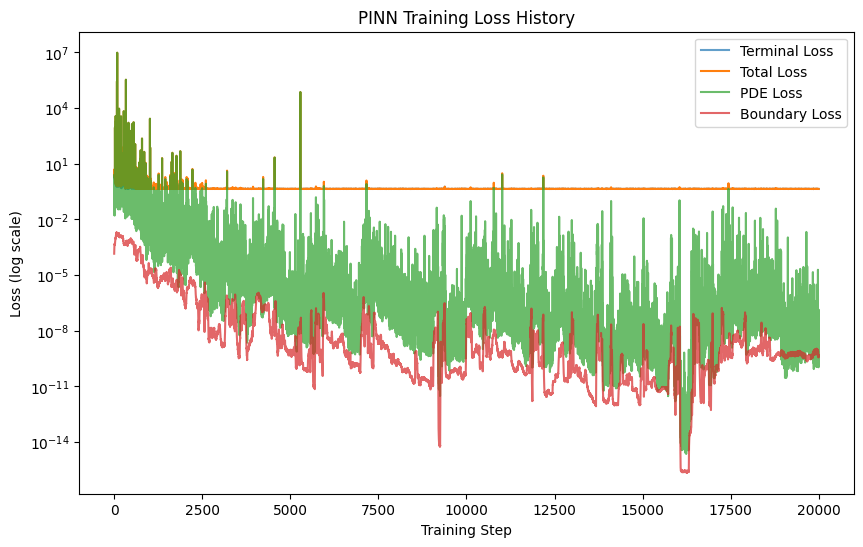

In [22]:
plt.figure(figsize=(10,6))
plt.plot(term_history, label='Terminal Loss', alpha=0.7)

plt.plot(loss_history, label='Total Loss')
plt.plot(pde_history, label='PDE Loss', alpha=0.7)
plt.plot(bc_history, label='Boundary Loss', alpha=0.7)
plt.yscale('log')
plt.xlabel('Training Step')
plt.ylabel('Loss (log scale)')
plt.title('PINN Training Loss History')
plt.legend()
plt.show()

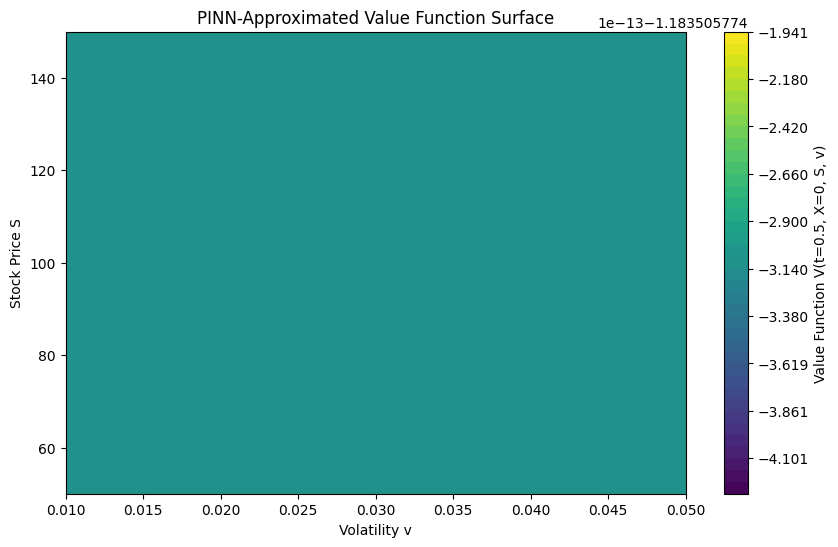

In [24]:
S_test = torch.linspace(50, 150, 100).to(device)
v_test = torch.linspace(v_min,v_max,80).to(device)
S_grid, v_grid = torch.meshgrid(S_test,v_test,indexing='ij')

tau_=torch.full_like(S_grid,0.5)
X_ = torch.full_like(S_grid,0.0)

V_pred = V_theta(torch.cat([
    tau_.reshape(-1,1),
    X_.reshape(-1,1),
    S_grid.reshape(-1,1),
    v_grid.reshape(-1,1)
], dim=1)).detach().cpu().numpy()

V_pred = V_pred.reshape(len(S_test), len(v_test))


plt.figure(figsize=(10,6))
plt.contourf(v_test.cpu(), S_test.cpu(), V_pred, 40, cmap='viridis')
plt.colorbar(label='Value Function V(t=0.5, X=0, S, v)')
plt.xlabel('Volatility v')
plt.ylabel('Stock Price S')
plt.title('PINN-Approximated Value Function Surface')
plt.show()

Using an AI refined code.
- Clamps pi value
- normalize inputs
- 10x on terminal loss (too weak) and 0.01x on boundary loss (too strong)


In [29]:
import torch.nn as nn
import torch.optim as optim
# -------------------------------------------------
# Parameters
# -------------------------------------------------
mu, r = 0.10, 0.02
kappa, theta, xi, rho = 2.0, 0.04, 0.30, -0.70
gamma = 2.0                      # CARA risk aversion
K, T = 100.0, 1.0

# Domains
X_min, X_max = -5.0, 60.0
S_min, S_max = 50.0, 150.0
v_min, v_max = 0.01, 0.05
t_min, t_max = 0.0, T

# Sample sizes
N_int  = 8000
N_term = 50000
N_b    = 1000

# -------------------------------------------------
# Helpers
# -------------------------------------------------
def call_payoff(S):
    return torch.clamp(S - K, min=0.0)

def sample_uniform(n, low, high):
    return low + (high - low) * torch.rand(n, 1, device=device)

# Simple affine normalization to roughly [-1, 1]
def normalize_inputs(t, X, S, v):
    t_n = 2.0 * (t - t_min) / (t_max - t_min) - 1.0
    X_n = 2.0 * (X - X_min) / (X_max - X_min) - 1.0
    S_n = 2.0 * (S - S_min) / (S_max - S_min) - 1.0
    v_n = 2.0 * (v - v_min) / (v_max - v_min) - 1.0
    return t_n, X_n, S_n, v_n

# -------------------------------------------------
# Network
# -------------------------------------------------
class FeedForwardNet(nn.Module):
    def __init__(self, in_dim=4, h1=128, h2=128, h3=64):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.out = nn.Linear(h3, 1)
        self.act = nn.Tanh()

    def forward(self, t, X, S, v):
        t_n, X_n, S_n, v_n = normalize_inputs(t, X, S, v)
        x = torch.cat([t_n, X_n, S_n, v_n], dim=1)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        return self.out(x)

V_theta = FeedForwardNet().to(device)
opt = optim.Adam(V_theta.parameters(), lr=1e-3)

# -------------------------------------------------
# Terminal condition (calendar time t = T)
# -------------------------------------------------
def V_terminal(X, S):
    arg = -gamma * (X - call_payoff(S))
    arg = torch.clamp(arg, min=-6.0, max=6.0)  # avoid overflow
    return -torch.exp(arg)

# -------------------------------------------------
# Autograd helper
# -------------------------------------------------
def V_and_grads(t, X, S, v):
    t.requires_grad_(True)
    X.requires_grad_(True)
    S.requires_grad_(True)
    v.requires_grad_(True)

    V = V_theta(t, X, S, v)

    ones = torch.ones_like(V)
    V_t  = torch.autograd.grad(V, t, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    V_X  = torch.autograd.grad(V, X, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    V_S  = torch.autograd.grad(V, S, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    V_v  = torch.autograd.grad(V, v, grad_outputs=ones, retain_graph=True, create_graph=True)[0]

    V_XX = torch.autograd.grad(V_X, X, grad_outputs=torch.ones_like(V_X), retain_graph=True, create_graph=True)[0]
    V_SS = torch.autograd.grad(V_S, S, grad_outputs=torch.ones_like(V_S), retain_graph=True, create_graph=True)[0]
    V_vv = torch.autograd.grad(V_v, v, grad_outputs=torch.ones_like(V_v), retain_graph=True, create_graph=True)[0]

    V_XS = torch.autograd.grad(V_X, S, grad_outputs=torch.ones_like(V_X), retain_graph=True, create_graph=True)[0]
    V_Xv = torch.autograd.grad(V_X, v, grad_outputs=torch.ones_like(V_X), retain_graph=True, create_graph=True)[0]
    V_Sv = torch.autograd.grad(V_S, v, grad_outputs=torch.ones_like(V_S), retain_graph=True, create_graph=True)[0]

    return V, V_t, V_X, V_S, V_v, V_XX, V_SS, V_vv, V_XS, V_Xv, V_Sv

# -------------------------------------------------
# HJB residual (calendar time t)
# -------------------------------------------------
def hjb_residual(t, X, S, v):
    V, V_t, V_X, V_S, V_v, V_XX, V_SS, V_vv, V_XS, V_Xv, V_Sv = V_and_grads(t, X, S, v)

    # Drift & diffusion terms (deterministic)
    drift_X = r * X * V_X
    drift_v = kappa * (theta - v) * V_v
    drift_S = mu * S * V_S
    diff_S  = 0.5 * v * S**2 * V_SS
    diff_v  = 0.5 * xi**2 * v * V_vv
    mix_Sv  = rho * xi * S * torch.clamp(v, min=1e-8) * V_Sv

    # Optimal control pi*
    num = -((mu - r) * V_X + v * S * V_XS + rho * xi * v * V_Xv)
    den = v * V_XX

    # Clamp denominator to avoid blow-ups; enforce concavity
    # If den is too close to zero or positive, push it to a small negative value
    den_safe = torch.where(den < -1e-4, den, -1e-4 * torch.ones_like(den))
    pi_opt = num / den_safe

    # HJB residual: V_t + L^{pi*} V = 0
    R = (V_t
         + drift_X + drift_v + drift_S + diff_S + diff_v + mix_Sv
         + pi_opt * (mu - r) * V_X
         + 0.5 * v * (pi_opt**2) * V_XX
         + pi_opt * v * S * V_XS
         + pi_opt * rho * xi * v * V_Xv)

    return R, V

# -------------------------------------------------
# Boundary loss (Neumann in S and v)
# -------------------------------------------------
def boundary_loss(m=N_b):
    # Stock boundaries
    t_b = sample_uniform(m, t_min, t_max)
    X_b = sample_uniform(m, X_min, X_max)
    v_b = sample_uniform(m, v_min, v_max)

    S_lo = torch.full_like(t_b, S_min)
    S_hi = torch.full_like(t_b, S_max)

    _, _, _, V_S_lo, _, _, _, _, _, _, _ = V_and_grads(t_b, X_b, S_lo, v_b)
    _, _, _, V_S_hi, _, _, _, _, _, _, _ = V_and_grads(t_b, X_b, S_hi, v_b)

    loss_S = (V_S_lo**2).mean() + (V_S_hi**2).mean()

    # Volatility boundaries
    t_b2 = sample_uniform(m, t_min, t_max)
    S_b2 = sample_uniform(m, S_min, S_max)
    X_b2 = sample_uniform(m, X_min, X_max)

    v_lo = torch.full_like(t_b2, v_min)
    v_hi = torch.full_like(t_b2, v_max)

    _, _, _, _, V_v_lo, _, _, _, _, _, _ = V_and_grads(t_b2, X_b2, S_b2, v_lo)
    _, _, _, _, V_v_hi, _, _, _, _, _, _ = V_and_grads(t_b2, X_b2, S_b2, v_hi)

    loss_v = (V_v_lo**2).mean() + (V_v_hi**2).mean()

    return loss_S + loss_v

# -------------------------------------------------
# Training loop
# -------------------------------------------------
loss_history, pde_history, term_history, bc_history = [], [], [], []

def train(steps=20000):
    for it in range(steps):
        # Interior samples (PDE)
        t   = sample_uniform(N_int, t_min, t_max)
        X   = sample_uniform(N_int, X_min, X_max)
        S   = sample_uniform(N_int, S_min, S_max)
        v   = sample_uniform(N_int, v_min, v_max)

        R, _ = hjb_residual(t, X, S, v)
        loss_pde = (R**2).mean()

        # Terminal condition at t = T
        t_T = torch.full((N_term, 1), T, device=device)
        S0  = sample_uniform(N_term, S_min, S_max)
        v0  = sample_uniform(N_term, v_min, v_max)
        H0  = call_payoff(S0)

        eps = torch.empty_like(H0).uniform_(-0.5, 0.5)  # wealth near payoff
        X0  = H0 + eps

        V_T_pred = V_theta(t_T, X0, S0, v0)
        V_T_true = V_terminal(X0, S0)
        loss_term = ((V_T_pred - V_T_true)**2).mean()

        # Boundary loss
        loss_bc = boundary_loss()

        # Weights: terminal strongest, PDE next, boundary weakest
        loss = 10.0 * loss_term + loss_pde + 0.01 * loss_bc

        opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(V_theta.parameters(), 5.0)
        opt.step()

        loss_history.append(loss.item())
        pde_history.append(loss_pde.item())
        term_history.append(loss_term.item())
        bc_history.append(loss_bc.item())

        if it % 200 == 0:
            print(f"[{it:5d}] total={loss.item():.3e} "
                  f"pde={loss_pde.item():.3e} term={loss_term.item():.3e} bc={loss_bc.item():.3e}")

# Run training
train(steps=10000)


[    0] total=1.776e+01 pde=1.479e-02 term=1.763e+00 bc=1.235e+01
[  200] total=4.305e+00 pde=1.289e-03 term=4.302e-01 bc=2.240e-01
[  400] total=4.130e+00 pde=2.310e-02 term=4.096e-01 bc=1.146e+00
[  600] total=3.899e+00 pde=5.272e-02 term=3.832e-01 bc=1.448e+00
[  800] total=3.760e+00 pde=7.692e-02 term=3.595e-01 bc=8.743e+00
[ 1000] total=3.396e+00 pde=8.860e-02 term=3.263e-01 bc=4.437e+00
[ 1200] total=3.252e+00 pde=1.178e-01 term=3.101e-01 bc=3.320e+00
[ 1400] total=3.007e+00 pde=9.894e-02 term=2.881e-01 bc=2.757e+00
[ 1600] total=2.955e+00 pde=1.129e-01 term=2.804e-01 bc=3.784e+00
[ 1800] total=2.697e+00 pde=1.244e-01 term=2.558e-01 bc=1.447e+00
[ 2000] total=2.587e+00 pde=1.336e-01 term=2.437e-01 bc=1.675e+00
[ 2200] total=2.734e+00 pde=1.668e-01 term=2.480e-01 bc=8.692e+00
[ 2400] total=2.563e+00 pde=1.189e-01 term=2.428e-01 bc=1.602e+00
[ 2600] total=2.552e+00 pde=1.363e-01 term=2.250e-01 bc=1.660e+01
[ 2800] total=2.271e+00 pde=1.258e-01 term=2.124e-01 bc=2.075e+00
[ 3000] to

Sensitivity of Value function surface with Stock price and time

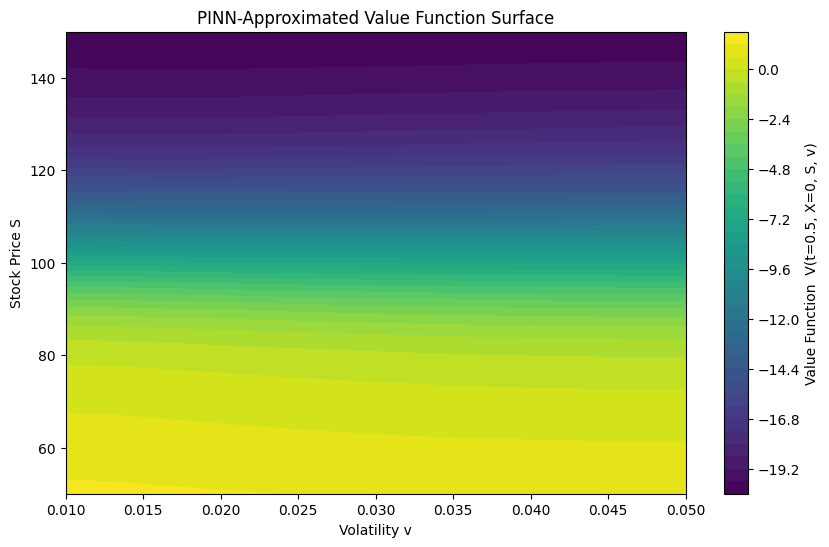

In [31]:
S_test = torch.linspace(50, 150, 100).to(device)
v_test = torch.linspace(v_min, v_max, 80).to(device)

S_grid, v_grid = torch.meshgrid(S_test, v_test, indexing='ij')

t_test = torch.full_like(S_grid, 0.5)     # calendar time t = 0.5
X_test = torch.full_like(S_grid, 0.0)     # hedging error / wealth deviation

# ---- Evaluate the value function ----
V_pred = V_theta(
    t_test.reshape(-1,1),
    X_test.reshape(-1,1),
    S_grid.reshape(-1,1),
    v_grid.reshape(-1,1)
).detach().cpu().numpy()

V_pred = V_pred.reshape(len(S_test), len(v_test))

# ---- Plot ----
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.contourf(v_test.cpu(), S_test.cpu(), V_pred, 40, cmap='viridis')
plt.colorbar(label='Value Function  V(t=0.5, X=0, S, v)')
plt.xlabel('Volatility v')
plt.ylabel('Stock Price S')
plt.title('PINN-Approximated Value Function Surface')
plt.show()

This graph shows if S is close to strike, then our payoff is equal to -1. If S is deep out of the money, the payoff is near zero and our value function reaches 0. If S is deep in the money, the payoff is large and the value function becomes very negative, ie -exp(positive)

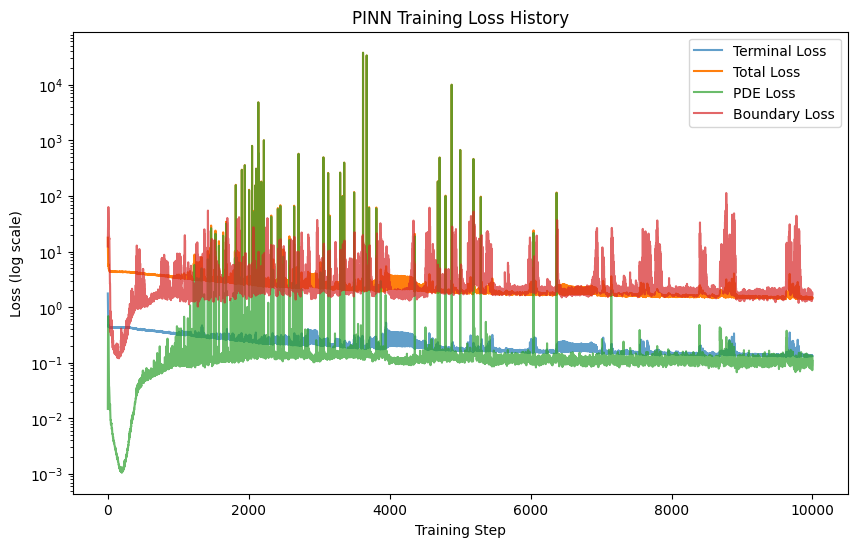

In [32]:
plt.figure(figsize=(10,6))
plt.plot(term_history, label='Terminal Loss', alpha=0.7)

plt.plot(loss_history, label='Total Loss')
plt.plot(pde_history, label='PDE Loss', alpha=0.7)
plt.plot(bc_history, label='Boundary Loss', alpha=0.7)
plt.yscale('log')
plt.xlabel('Training Step')
plt.ylabel('Loss (log scale)')
plt.title('PINN Training Loss History')
plt.legend()
plt.show()

Plotting the sensitivity of the optimal hedging strategy to the stock price and time

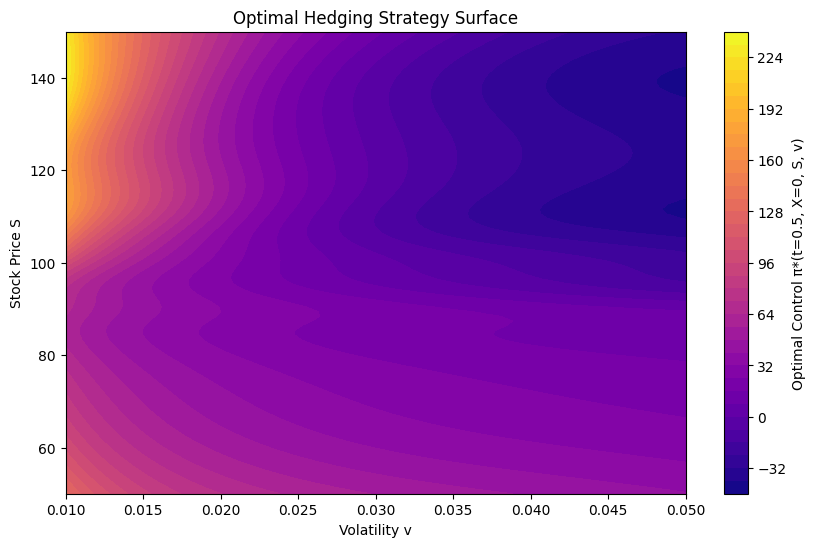

In [34]:
def compute_pi_star(t, X, S, v):
    # Get V and all needed derivatives
    V, V_t, V_X, V_S, V_v, V_XX, V_SS, V_vv, V_XS, V_Xv, V_Sv = \
        V_and_grads(t, X, S, v)
    
    # Numerator and denominator
    num = -((mu - r) * V_X + v * S * V_XS + rho * xi * v * V_Xv)
    den = v * V_XX

    # Stabilize denominator (same as in training)
    den_safe = torch.where(den < -1e-4, 
                           den, 
                           -1e-4 * torch.ones_like(den))

    pi_star = num / den_safe
    return pi_star

S_test = torch.linspace(50, 150, 100).to(device)
v_test = torch.linspace(v_min, v_max, 80).to(device)

S_grid, v_grid = torch.meshgrid(S_test, v_test, indexing='ij')

t_grid  = torch.full_like(S_grid, 0.5)   # t = 0.5
X_grid  = torch.full_like(S_grid, 0.0)   # X = 0


pi_vals = compute_pi_star(
    t_grid.reshape(-1,1),
    X_grid.reshape(-1,1),
    S_grid.reshape(-1,1),
    v_grid.reshape(-1,1)
)

pi_vals = pi_vals.detach().cpu().numpy()
pi_vals = pi_vals.reshape(len(S_test), len(v_test))


plt.figure(figsize=(10,6))
plt.contourf(v_test.cpu(), S_test.cpu(), pi_vals, 40, cmap='plasma')
plt.colorbar(label='Optimal Control π*(t=0.5, X=0, S, v)')
plt.xlabel('Volatility v')
plt.ylabel('Stock Price S')
plt.title('Optimal Hedging Strategy Surface')
plt.show()




This graph makes sense. For higher values of the stock price, the option is deep into the money and the amount that we put into the replicating portfolio should be higher. Pi should increase with S, as shown in the graph. Pi should also decrease with volatility since under higher volatility, the investor should be more cautious and hedging becomes more expensive and risky.

Plotting the sensitivity of the Optimal hedging portfolio with respect to time

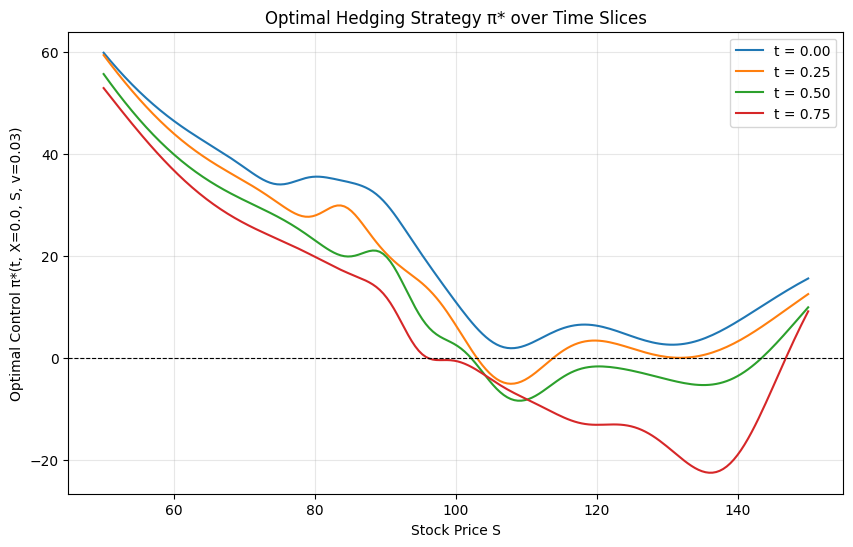

In [38]:
def plot_pi_over_time_slices(times, X0=0.0, v0=0.03):
    """
    Plot π*(t, X=X0, S, v=v0) as a function of S, for several time points.
    """
    S_test = torch.linspace(S_min, S_max, 200).to(device)
    
    plt.figure(figsize=(10,6))
    
    for t_val in times:
        # Create tensors for this time slice
        t_tensor = torch.full_like(S_test, t_val)
        X_tensor = torch.full_like(S_test, X0)
        v_tensor = torch.full_like(S_test, v0)
        
        # Compute π* on this 1D grid of S
        pi_vals = compute_pi_star(
            t_tensor.view(-1,1),
            X_tensor.view(-1,1),
            S_test.view(-1,1),
            v_tensor.view(-1,1)
        ).detach().cpu().numpy().flatten()
        
        plt.plot(S_test.cpu().numpy(), pi_vals, label=f"t = {t_val:.2f}")
    
    plt.axhline(0, color='k', linewidth=0.8, linestyle='--')
    plt.xlabel("Stock Price S")
    plt.ylabel("Optimal Control π*(t, X=%.1f, S, v=%.2f)" % (X0, v0))
    plt.title("Optimal Hedging Strategy π* over Time Slices")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Example usage:
time_slices = [0.0, 0.25, 0.5, 0.75]   # calendar times
plot_pi_over_time_slices(time_slices, X0=0.0, v0=0.03)

Sensitivity analysis of pi with volatility 

In [39]:
def plot_pi_t_v_slice(S_fixed=100.0, X_fixed=0.0):
    # Time and volatility grids
    t_vals = torch.linspace(t_min, t_max, 60).to(device)   # 60 time points
    v_vals = torch.linspace(v_min, v_max, 60).to(device)   # 60 vol points
    
    t_grid, v_grid = torch.meshgrid(t_vals, v_vals, indexing='ij')
    
    # Fix S and X
    S_grid = torch.full_like(t_grid, S_fixed)
    X_grid = torch.full_like(t_grid, X_fixed)

    # Compute π*
    pi_vals = compute_pi_star(
        t_grid.reshape(-1,1),
        X_grid.reshape(-1,1),
        S_grid.reshape(-1,1),
        v_grid.reshape(-1,1)
    ).detach().cpu().numpy()
    
    pi_vals = pi_vals.reshape(len(t_vals), len(v_vals))

    # Plot
    plt.figure(figsize=(10,6))
    plt.contourf(v_vals.cpu(), t_vals.cpu(), pi_vals, 40, cmap='coolwarm')
    plt.colorbar(label='Optimal Control π*(t, X=0, S=%d, v)' % S_fixed)
    plt.xlabel('Volatility v')
    plt.ylabel('Time t')
    plt.title('Optimal Hedging Strategy π*(t, v) for S = %d' % S_fixed)
    plt.show()


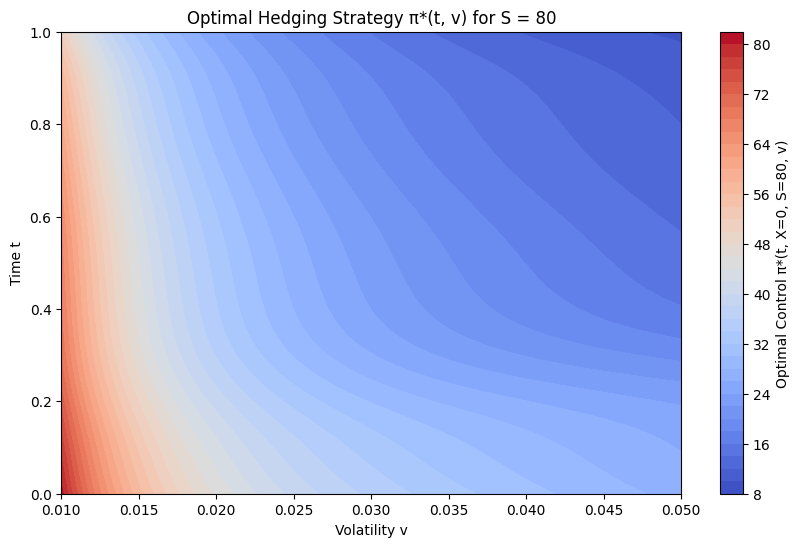

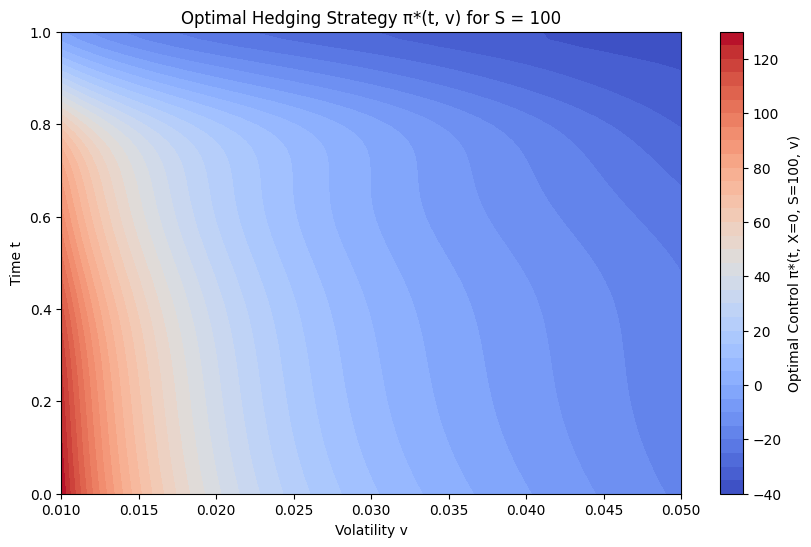

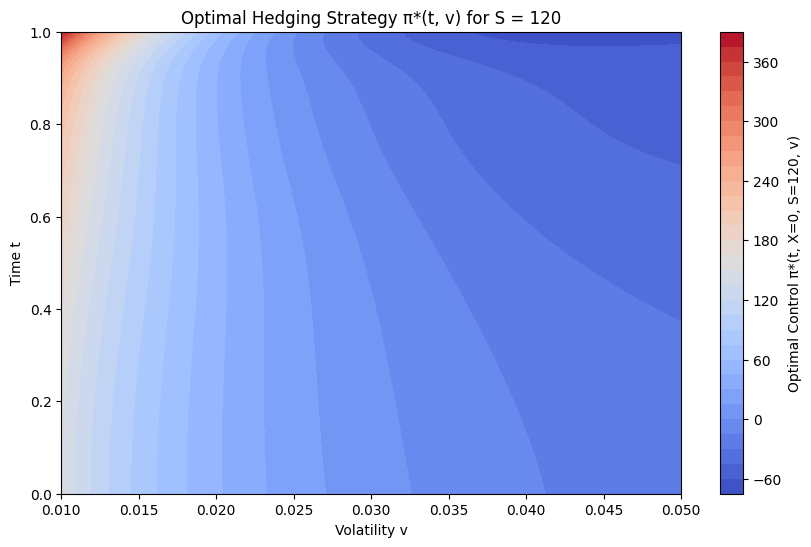

In [40]:
plot_pi_t_v_slice(S_fixed=80)   # OTM slice
plot_pi_t_v_slice(S_fixed=100)  # ATM slice
plot_pi_t_v_slice(S_fixed=120)  # ITM slice

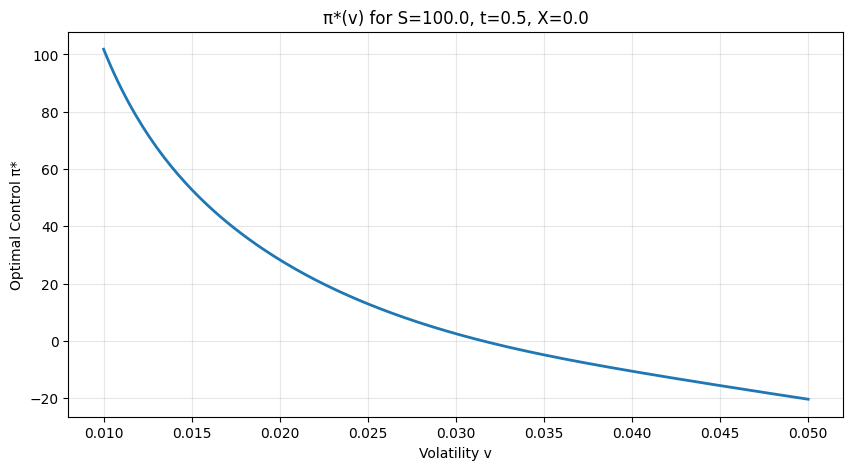

In [43]:
def plot_pi_vs_vol(t_fixed=0.5, X_fixed=0.0, S_fixed=100.0):
    v_vals = torch.linspace(v_min, v_max, 200).to(device)

    t_tensor = torch.full_like(v_vals, t_fixed)
    X_tensor = torch.full_like(v_vals, X_fixed)
    S_tensor = torch.full_like(v_vals, S_fixed)

    pi_vals = compute_pi_star(
        t_tensor.view(-1,1),
        X_tensor.view(-1,1),
        S_tensor.view(-1,1),
        v_vals.view(-1,1)
    ).detach().cpu().numpy().flatten()

    plt.figure(figsize=(10,5))
    plt.plot(v_vals.cpu(), pi_vals, linewidth=2)
    plt.xlabel("Volatility v")
    plt.ylabel("Optimal Control π*")
    plt.title(f"π*(v) for S={S_fixed}, t={t_fixed}, X={X_fixed}")
    plt.grid(True, alpha=0.3)
    plt.show()
plot_pi_vs_vol()

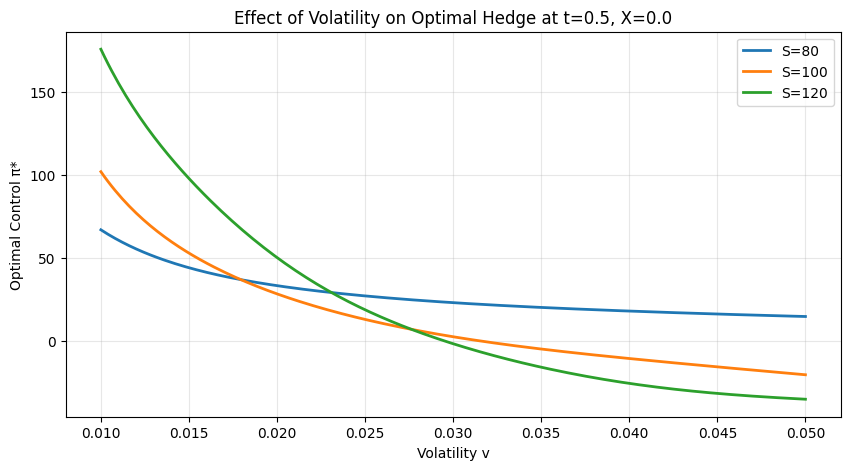

In [44]:
def plot_pi_vs_vol_multiS(t_fixed=0.5, X_fixed=0.0, S_list=[80, 100, 120]):
    v_vals = torch.linspace(v_min, v_max, 200).to(device)

    plt.figure(figsize=(10,5))

    for S_fixed in S_list:
        t_tensor = torch.full_like(v_vals, t_fixed)
        X_tensor = torch.full_like(v_vals, X_fixed)
        S_tensor = torch.full_like(v_vals, S_fixed)

        pi_vals = compute_pi_star(
            t_tensor.view(-1,1),
            X_tensor.view(-1,1),
            S_tensor.view(-1,1),
            v_vals.view(-1,1)
        ).detach().cpu().numpy().flatten()

        plt.plot(v_vals.cpu(), pi_vals, linewidth=2, label=f"S={S_fixed}")

    plt.xlabel("Volatility v")
    plt.ylabel("Optimal Control π*")
    plt.title(f"Effect of Volatility on Optimal Hedge at t={t_fixed}, X={X_fixed}")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
plot_pi_vs_vol_multiS()